## Importing Required Libraries

In [4]:
import os
import argparse
import logging
import sys
from typing import Dict, List
from dpu_utils.utils.richpath import RichPath
import pickle

import torch
from tqdm import tqdm
import pandas as pd

# Setting up local details:
# This should be the location of the checkout of the FS-Mol repository:
FS_MOL_CHECKOUT_PATH = os.path.join("/data/local/apps/", "Meta-Learning", "FS-Mol")
FS_MOL_DATASET_PATH = os.path.join("/data/local/apps/", "Meta-Learning", "FS-Mol", "datasets")

os.chdir(FS_MOL_CHECKOUT_PATH)
sys.path.insert(0, FS_MOL_CHECKOUT_PATH)

In [5]:
from fs_mol.data import FSMolDataset
from fs_mol.models.abstract_torch_fsmol_model import resolve_starting_model_file
from fs_mol.models.protonet import PrototypicalNetwork
from fs_mol.utils.protonet_utils import (
    PrototypicalNetworkTrainer,
    evaluate_protonet_model,
)
from fs_mol.utils.test_utils import add_eval_cli_args, set_up_test_run


## Prototypical Networks Representation

In [ ]:
'''
parser = argparse.ArgumentParser(
        description="Test a Prototypical Network model on molecules.",)


parser.add_argument(
        "TRAINED_MODEL",
        type=str,
        required=False,
        help="File to load model from (determines model architecture).",
        default='checkpoints/PN-Support64_best_validation.pt'
    )

add_eval_cli_args(parser)

parser.add_argument(
    "--batch-size",
    type=int,
    default=320,
    help="Maximum batch size to allow when running through inference on model.",
)
    
parser.add_argument(
    "--use-fresh-param-init",
    action="store_true",
    help="Do not use trained weights, but start from a fresh, random initialisation.",
)

args = parser.parse_args()
'''

In [3]:
config = {'TRAINED_MODEL': 'checkpoints/PN-Support64_best_validation.pt'}

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# This just return the path to the model file. If the model checkpoint is available, it 
# will be the corresponding path. Otherwise, it creates a new model pickle file and returns the path
# to that file.
model_weights_file = resolve_starting_model_file(
    model_file=config['TRAINED_MODEL'],
    model_cls=PrototypicalNetworkTrainer,
    out_dir='tmp/results',
    use_fresh_param_init=False,
    device=device,
)

Device: cuda


In [5]:
model = PrototypicalNetworkTrainer.build_from_model_file(
    model_weights_file,
    device=device,
)

In [9]:
model.__class__.__name__

'PrototypicalNetworkTrainer'

In [3]:
from fs_mol.data import FSMolDataset, DataFold
dataset = FSMolDataset.from_directory(FS_MOL_DATASET_PATH, task_list_file=os.path.join(FS_MOL_DATASET_PATH, "fsmol-0.1.json"))

# This will create a list of all tasks in the test tasks. Each task contains `MolculeDatapoint` objects
test_tasks = []
# next line will create iterable object that will iterate over all tasks in the test dataset
test_task_iterable = dataset.get_task_reading_iterable(DataFold.TEST)
for task in tqdm(iter(test_task_iterable)):
    test_tasks.append(task)

157it [00:01, 78.85it/s] 


In [4]:
from fs_mol.data import FSMolDataset, DataFold
dataset = FSMolDataset.from_directory(FS_MOL_DATASET_PATH, task_list_file=os.path.join(FS_MOL_DATASET_PATH, "fsmol-0.1.json"))

# This will create a list of all tasks in the test tasks. Each task contains `MolculeDatapoint` objects
a = []
# next line will create iterable object that will iterate over all tasks in the test dataset
test_task_iterable = dataset.get_task_reading_iterable(DataFold.TEST)
for task in tqdm(iter(test_task_iterable)):
    a.append(task)

157it [00:02, 69.47it/s] 


In [9]:
sum([item.name == a[i].name for i, item in enumerate(test_tasks)])

11

In [11]:
train_tasks = []
train_task_iterable = dataset.get_task_reading_iterable(DataFold.TRAIN)
for task in tqdm(iter(train_task_iterable)):
    train_tasks.append(task)

4938it [00:13, 353.30it/s]


In [9]:
import torch
import numpy as np

support_features = torch.Tensor(np.array([item.fingerprint for item in test_tasks[0].samples]))
support_labels = torch.Tensor(np.array([item.bool_label for item in test_tasks[0].samples]))

In [10]:
support_features.shape

torch.Size([187, 2048])

In [12]:
# `compute_class_prototypes` requires two arguments: the support features and the support labels
# The support features are the features of the support set
# The support labels are the labels of the support set

prototypes = model._compute_class_prototypes(support_features, support_labels)

In [52]:
def compute_prototype(task) -> torch.Tensor:
    support_features = torch.Tensor(np.array([item.fingerprint for item in task.samples]))
    support_labels = torch.Tensor(np.array([item.bool_label for item in task.samples]))
    prototypes = model._compute_class_prototypes(support_features, support_labels)
    return prototypes

In [28]:
test_prototypes = [compute_prototype(task) for task in tasks]

In [29]:
train_prototypes = [compute_prototype(task) for task in train_tasks]

In [30]:
print(len(test_prototypes))
print(len(train_prototypes))

157
4938


In [31]:
neg_test_prototypes = torch.stack([prototypes[0] for prototypes in test_prototypes], dim=0)
pos_test_prototypes = torch.stack([prototypes[1] for prototypes in test_prototypes], dim=0)

neg_train_prototypes = torch.stack([prototypes[0] for prototypes in train_prototypes], dim=0)
pos_train_prototypes = torch.stack([prototypes[1] for prototypes in train_prototypes], dim=0)

In [33]:
print(neg_test_prototypes.shape)
print(pos_test_prototypes.shape)
print(neg_train_prototypes.shape)
print(pos_train_prototypes.shape)

torch.Size([157, 2048])
torch.Size([157, 2048])
torch.Size([4938, 2048])
torch.Size([4938, 2048])


In [31]:
labels = [0] * len(pos_train_prototypes) + [1] * len(pos_test_prototypes)

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import pandas as pd


light_color = plt.get_cmap("plasma").colors[170]
dark_color = "black"

plt.rcParams.update(
    {
        "font.size": 20,
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": "Computer Modern Roman",
    }
)

def visualize_tsne(dataset: torch.Tensor):
    """Visualizes the t-SNE embedding of the given dataset.
    
    dataset: torch.Tensor of shape (N, D) where N is the number of samples and D is the dimension of the embedding.
    """
    labels_dict = {0: "Train", 1: "Test"}
    labels_leg = [labels_dict[item] for item in labels]
    tsne = TSNE(n_components=2, verbose=1, random_state=123)
    tsne_embedding = tsne.fit_transform(dataset.detach().numpy())

    size_map = [item*10 + 12 for item in labels]

    df = pd.DataFrame()
    df["y"] = labels
    df["comp-1"] = tsne_embedding[:,0]
    df["comp-2"] = tsne_embedding[:,1]

    _, ax = plt.subplots(1, 1, figsize=(15, 15))

    """
    sns.scatterplot(ax=ax, x="Component_1", y="Component_2", hue=df.y.tolist(),
                    palette=sns.color_palette("hls", 2),
                    data=df).set(title="FS-MOL T-SNE projection of Protein/Task ESM Embedding")
    """
    ax.scatter(tsne_embedding[:, 0], tsne_embedding[:, 1], s=size_map, c=labels, cmap='Paired')
    ax.legend([labels_leg[i] for i in range(3)])
    ax.set_title("FS-Mol T-SNE Projection of Chemical Space Embedding")
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    plt.show()

/home/vscholz/miniconda3/envs/datamol/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/vscholz/miniconda3/envs/datamol/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5095 samples in 0.005s...
[t-SNE] Computed neighbors for 5095 samples in 0.823s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5095
[t-SNE] Computed conditional probabilities for sample 2000 / 5095
[t-SNE] Computed conditional probabilities for sample 3000 / 5095
[t-SNE] Computed conditional probabilities for sample 4000 / 5095
[t-SNE] Computed conditional probabilities for sample 5000 / 5095
[t-SNE] Computed conditional probabilities for sample 5095 / 5095
[t-SNE] Mean sigma: 0.468544
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.098686
[t-SNE] KL divergence after 1000 iterations: 1.873955


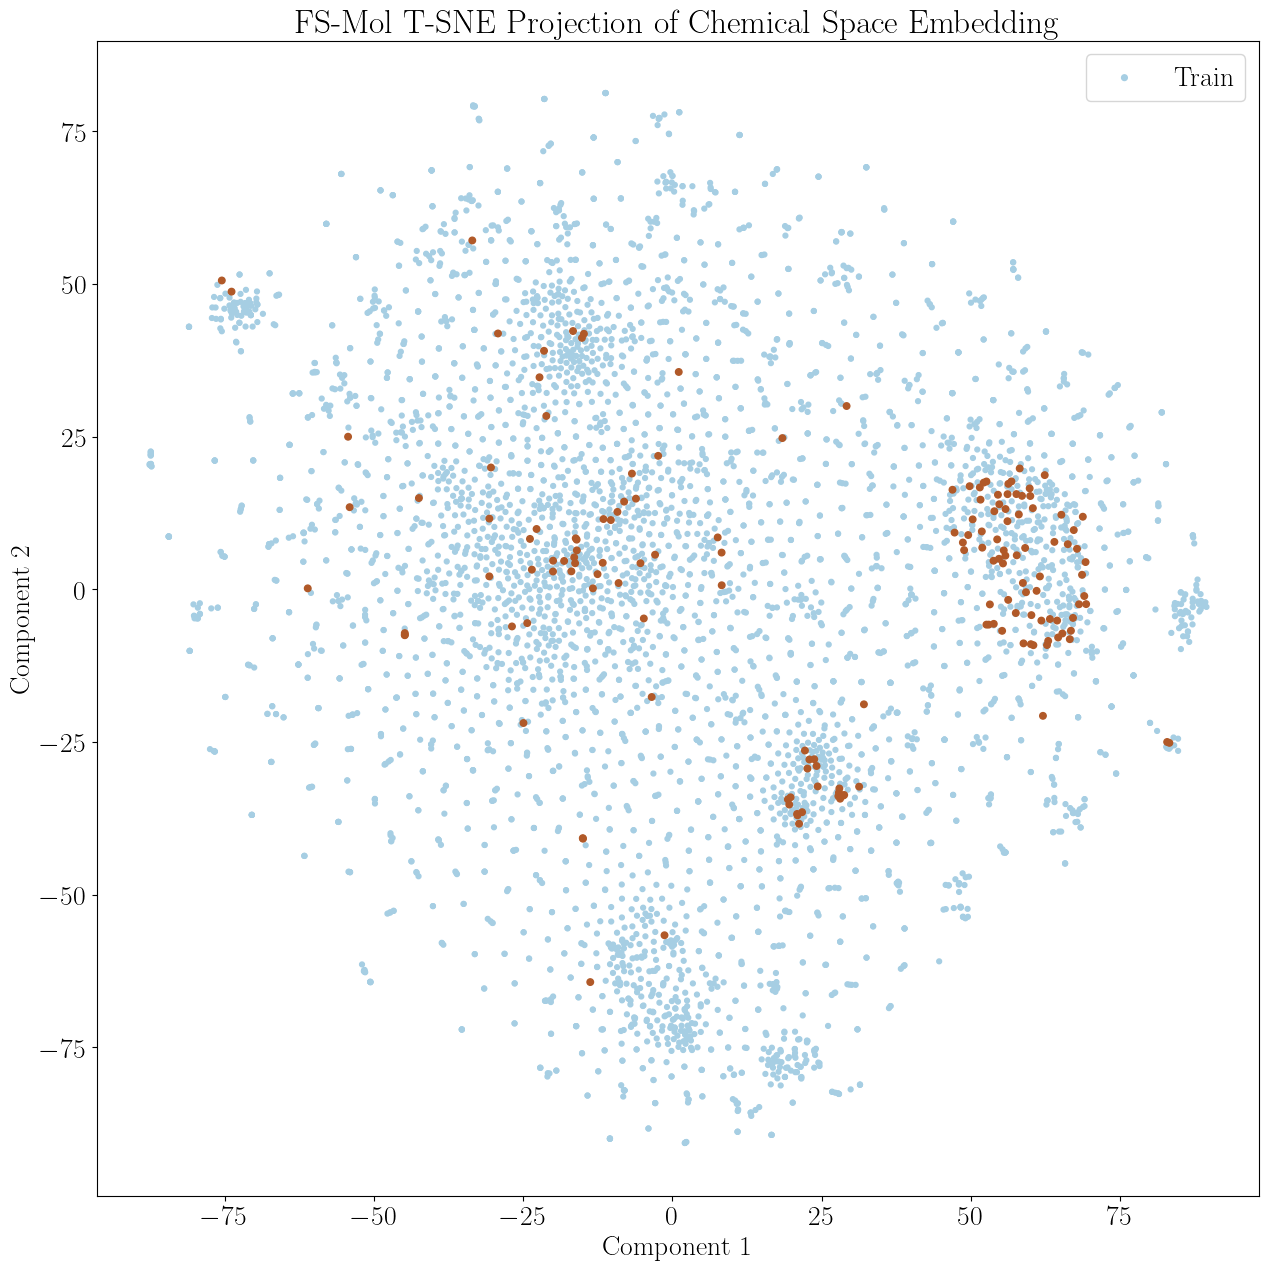

In [34]:
whole_pos_prototypes = torch.cat((neg_train_prototypes, neg_test_prototypes), 0)
visualize_tsne(whole_pos_prototypes)

In [ ]:
evaluate_protonet_model(
    model,
    dataset,
    support_sizes=[16],
    num_samples=1,
    seed=42,
    batch_size=32,
    save_dir=save_dir,
)

In [117]:
from fs_mol.data.fsmol_task import FSMolTaskSample

task_sample = FSMolTaskSample(tasks[0].name, [], [], tasks[0].samples)

In [118]:
from fs_mol.data.protonet import (
    ProtoNetBatch,
    get_protonet_task_sample_iterable,
    get_protonet_batcher,
    task_sample_to_pn_task_sample,
)
from fs_mol.utils.torch_utils import torchify

In [119]:
batcher = get_protonet_batcher(max_num_graphs=320)

In [120]:
pn_task_sample = torchify(
    task_sample_to_pn_task_sample(task_sample, batcher), device=model.device
)

IndexError: list index out of range

In [110]:
pn_task_sample.batch_labels

[]

## Extracting datamol representation for all the tasks

In [13]:
import pandas as pd
import datamol as dm
from molfeat.calc import FPCalculator
from molfeat.trans import MoleculeTransformer
from molfeat.store.modelstore import ModelStore

In [14]:
from molfeat.calc import FP_FUNCS
FP_FUNCS.keys()

dict_keys(['maccs', 'avalon', 'ecfp', 'fcfp', 'topological', 'atompair', 'rdkit', 'pattern', 'layered', 'map4', 'secfp', 'erg', 'estate', 'avalon-count', 'rdkit-count', 'ecfp-count', 'fcfp-count', 'topological-count', 'atompair-count'])

In [ ]:
# List all available featurizers
store = ModelStore()
store.available_models

In [42]:
calc = FPCalculator("ecfp")
transformer = MoleculeTransformer(calc, n_jobs=32)

In [145]:
from molfeat.trans.pretrained import GraphormerTransformer
from molfeat.trans.pretrained.hf_transformers import PretrainedHFTransformer

#transformer = GraphormerTransformer(kind='pcqm4mv2_graphormer_base', dtype=float)
transformer = PretrainedHFTransformer(kind='ChemBERTa-77M-MTR', notation='smiles', dtype=float, n_jobs=128)

In [106]:
from molfeat.trans.fp import FPVecTransformer
transformer = FPVecTransformer(kind='desc2D', dtype=float, n_jobs=32)

In [98]:
transformer = MoleculeTransformer(featurizer='mordred', dtype=float, n_jobs=32)

In [46]:
smiles = [item.smiles for item in test_tasks[0].samples]
labels = [item.bool_label for item in test_tasks[0].samples]

In [26]:
mol_trans = transformer(smiles)

In [18]:
import numpy as np
import torch

In [148]:
def compute_prototype_datamol(task, trans: MoleculeTransformer) -> torch.Tensor:
    support_smiles = [item.smiles for item in task.samples]
    support_features = torch.Tensor(np.array(trans(support_smiles)))
    support_labels = torch.Tensor(np.array([item.bool_label for item in task.samples]))
    prototypes = model._compute_class_prototypes(support_features, support_labels)
    return prototypes

In [149]:
test_prototypes =  [compute_prototype_datamol(task, transformer) for task in tqdm(test_tasks)]

  0%|          | 0/157 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

100%|██████████| 157/157 [03:02<00:00,  1.16s/it]


In [152]:
train_prototypes = [compute_prototype_datamol(task, transformer) for task in tqdm(train_tasks)]

  0%|          | 0/4938 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

100%|██████████| 4938/4938 [21:15<00:00,  3.87it/s]  


In [153]:
neg_test_prototypes = torch.stack([prototypes[0] for prototypes in test_prototypes], dim=0)
pos_test_prototypes = torch.stack([prototypes[1] for prototypes in test_prototypes], dim=0)

neg_train_prototypes = torch.stack([prototypes[0] for prototypes in train_prototypes], dim=0)
pos_train_prototypes = torch.stack([prototypes[1] for prototypes in train_prototypes], dim=0)

In [140]:
neg_train_prototypes1 = neg_train_prototypes[~torch.any(neg_train_prototypes.isnan(),dim=1)]

In [161]:
import pickle
path_to_save_embedding = 'train/embedding/ChemBERTa-77M-MTR_neg.pkl'
path_to_save_embedding = os.path.join(FS_MOL_DATASET_PATH, path_to_save_embedding)
with open(path_to_save_embedding, 'wb') as f:
    pickle.dump(neg_train_prototypes, f)
    

In [2]:
import pickle
path_to_save_embedding_train = 'train/embedding/pcqm4mv2_graphormer_base_pos.pkl'
path_to_save_embedding_train = os.path.join(FS_MOL_DATASET_PATH, path_to_save_embedding_train)

with open(path_to_save_embedding_train, 'rb') as f:
    x = pickle.load(f)

path_to_save_embedding_test = 'test/embedding/pcqm4mv2_graphormer_base_pos.pkl'
path_to_save_embedding_test = os.path.join(FS_MOL_DATASET_PATH, path_to_save_embedding_test)

with open(path_to_save_embedding_test, 'rb') as f:
    y = pickle.load(f)


In [3]:
pos_train_prototypes = torch.stack(list(x.values()), dim=0)
pos_test_prototypes = torch.stack(list(y.values()), dim=0)

In [4]:
labels = [0] * len(pos_train_prototypes) + [1] * len(pos_test_prototypes)

/home/vscholz/miniconda3/envs/datamol/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/vscholz/miniconda3/envs/datamol/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5095 samples in 0.002s...
[t-SNE] Computed neighbors for 5095 samples in 0.767s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5095
[t-SNE] Computed conditional probabilities for sample 2000 / 5095
[t-SNE] Computed conditional probabilities for sample 3000 / 5095
[t-SNE] Computed conditional probabilities for sample 4000 / 5095
[t-SNE] Computed conditional probabilities for sample 5000 / 5095
[t-SNE] Computed conditional probabilities for sample 5095 / 5095
[t-SNE] Mean sigma: 0.517092
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.549538
[t-SNE] KL divergence after 1000 iterations: 1.377212


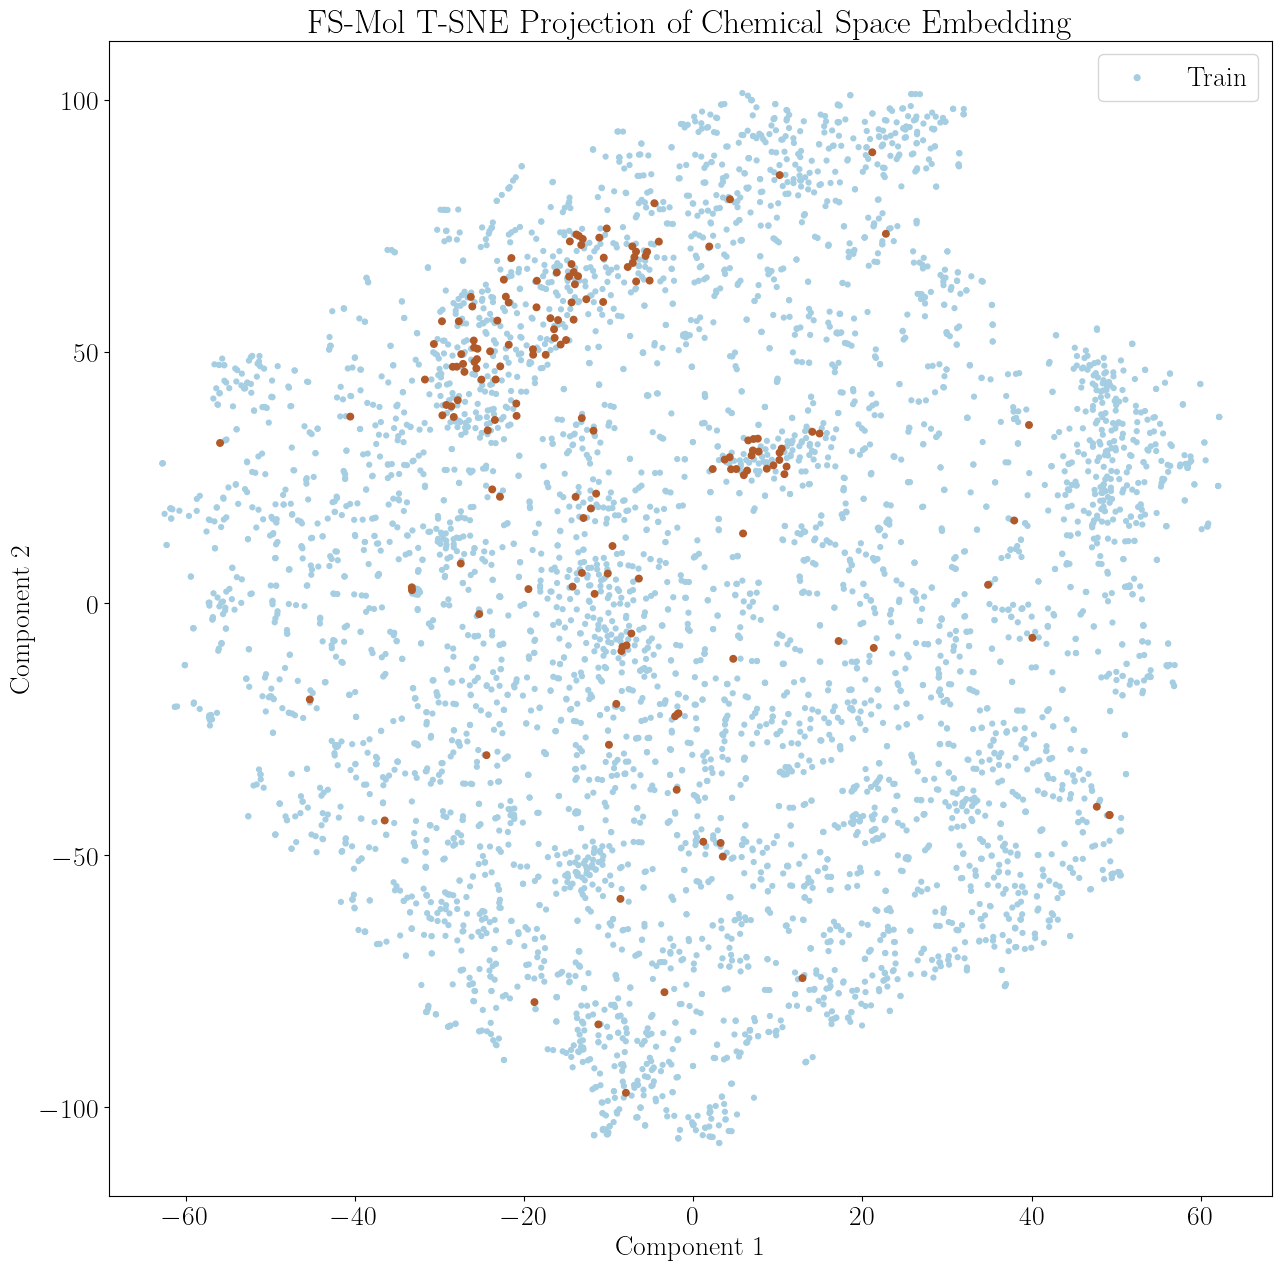

In [7]:
whole_pos_prototypes = torch.cat((pos_train_prototypes, pos_test_prototypes), 0)
visualize_tsne(whole_pos_prototypes)

In [128]:
sum([len(item)==214 for item in pos_test_prototypes])

157

In [129]:
len(pos_train_prototypes)

4938

In [75]:
with open('./datasets/train/embedding/ecfp_neg.pkl', 'rb') as f:
    x2 = pickle.load(f)

In [91]:
x =  [task.name for task in train_tasks]
y = [len(task.samples) for task in train_tasks]

In [92]:
import pandas as pd
df = pd.DataFrame({'task_name': x, 'num_samples': y})
df.to_csv('./datasets/train/embedding/metadata.csv', index=False)

array([[<AxesSubplot:title={'center':'num_samples'}>]], dtype=object)

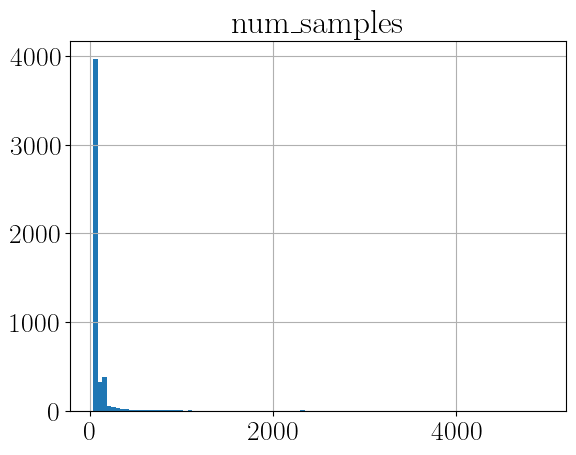

In [97]:
df.hist(bins=100)

## Visualizing task hardness based on different prototypes representation

In [12]:
## Importing and Setting visulization parameters and reading the data

%matplotlib inline

PATH_TO_HARDNESS_POS = os.path.join(FS_MOL_DATASET_PATH, "test/hardness/pcqm4mv2_graphormer_base_pos_cosine_0.01.csv")
PATH_TO_HARDNESS_NEG = os.path.join(FS_MOL_DATASET_PATH, "test/hardness/pcqm4mv2_graphormer_base_neg_cosine_0.01.csv")
hardness_df_pos = pd.read_csv(PATH_TO_HARDNESS_POS)
hardness_df_neg = pd.read_csv(PATH_TO_HARDNESS_NEG)

hardness_df = pd.merge(hardness_df_pos, hardness_df_neg, on='task_name')
hardness_df['hardness'] = hardness_df['hardness_x'] + hardness_df['hardness_y']
hardness_df.rename(columns = {'task_name':'assay'}, inplace = True)

print(hardness_df['hardness_x'].corr(hardness_df['hardness_y']))

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import pandas as pd


light_color = plt.get_cmap("plasma").colors[170]
dark_color = "black"

plt.rcParams.update(
    {
        "font.size": 20,
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": "Computer Modern Roman",
    }
)



0.9631559574839468


In [39]:
hardness_df.head()

,assay,hardness_x,hardness_y,hardness
0,CHEMBL1066254,0.013519,0.011049,0.024568
1,CHEMBL1006005,0.003572,0.001568,0.005140
2,CHEMBL1243967,0.004706,0.004447,0.009153
3,CHEMBL1613898,0.001032,0.001297,0.002329
4,CHEMBL1243970,0.004602,0.004588,0.009189


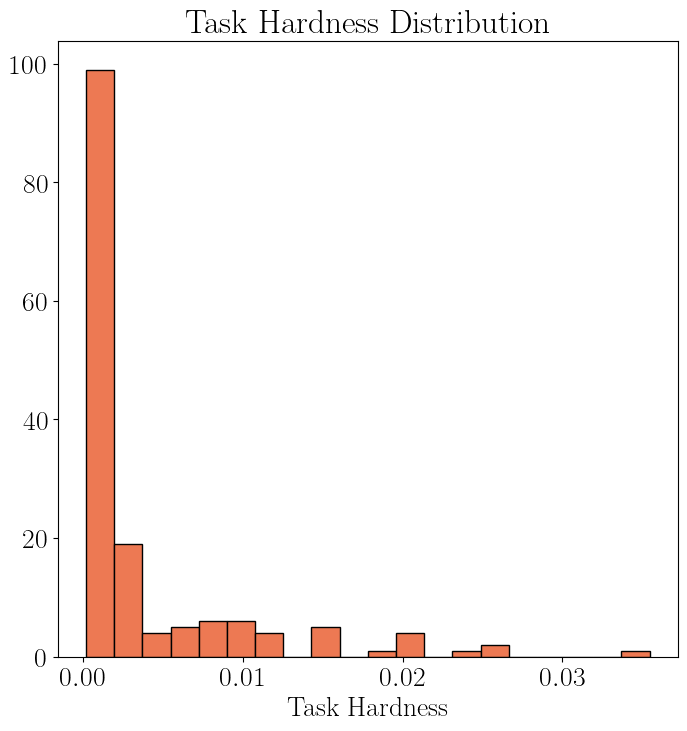

In [40]:
# Visualizing the Hardness Distribution
_, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.hist(hardness_df['hardness'], bins=20, color=light_color, edgecolor=dark_color)
ax.set_title("Task Hardness Distribution")
ax.set_xlabel("Task Hardness")
plt.show()

In [15]:
AVAILABLE_EXP_NAME = ["FSMol_Eval_ProtoNet_2023-02-15_12-21-54",
                      "FSMol_Eval_MAML_2023-02-17_14-14-19",]
exp_name = "FSMol_Eval_ProtoNet_2023-02-15_12-21-54"
model = "ProtoNet"
evaluation_output_directory = os.path.join(FS_MOL_CHECKOUT_PATH, "outputs", exp_name)
output_results = pd.read_csv(os.path.join(evaluation_output_directory, "summary", f"{model}_summary_num_train_requested_128.csv"))


0.040903911469198494
0.040903911469198494


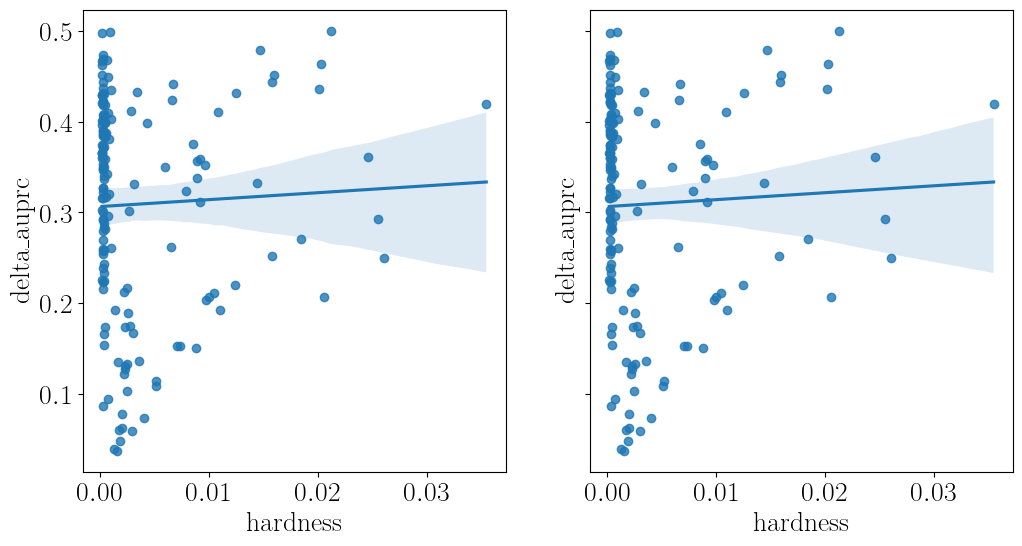

In [42]:
# Visualizing the Hardness vs Performance (Caclulated correlation)
import seaborn as sns
x = pd.merge(output_results[['assay', 'delta_auprc', 'roc_auc']], hardness_df, on="assay")
print(x['hardness'].corr( x['roc_auc']))

z = x[x['hardness'] < 125]
print(z['hardness'].corr( z['roc_auc']))

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(12, 6))
sns.regplot(x="hardness", y="delta_auprc",data=x, ax=ax1)
sns.regplot(x="hardness", y="delta_auprc",data=z, ax=ax2)
#ax[0].set(xlabel='chemical space hardness')
#ax[1].set(xlabel='chemical space hardness')
plt.show()

## Analysis of Optimal Transport Distance Between Datasets

In [32]:
available_otdd = ['test/hardness/otdd_Roberta-Zinc480M-102M.pkl',
                  'test/hardness/otdd_desc2D.pkl',
                  'test/hardness/otdd_gin_supervised_infomax.pkl',
                  'test/hardness/otdd_unimol.pkl',
]


In [33]:
def calculate_task_hardness_weight(chembl_ids: List, evaluated_resuts: Dict):
    weights=[]
    for chembl_id in chembl_ids:
        weights.append(evaluated_resuts[chembl_id][0].roc_auc)

    weights = torch.tensor(weights)
    return weights

In [62]:
def otdd_hardness(k=10, train_tasks_weighted=False) -> pd.DataFrame:    
    PATH_TO_OTDD = os.path.join(FS_MOL_DATASET_PATH, 'test/hardness/otdd_gin_supervised_infomax.pkl')
    with open(PATH_TO_OTDD, 'rb') as f:
        data = pickle.load(f)

    ## data is a dictionary with following keys:
    print(data.keys())

    ## data['distnce_matrices] is a list. We will convert it to the pytorch tensor
    distance_matrix = torch.stack(data['distance_matrices']) # shape: #TRAIN_TASK * TEST_TASKS
    distance_matrix_sorted,  distance_matrix_indices = torch.sort(distance_matrix, dim=0)

    if train_tasks_weighted:
        ## We will weight the distance matrix by the hardness of the closest train tasks
        with open(os.path.join(FS_MOL_DATASET_PATH, 'train/hardness_intra/rf_16.pkl'), 'rb') as f:
            train_tasks_hardness = pickle.load(f)
        weights = calculate_task_hardness_weight(data['train_chembl_ids'], train_tasks_hardness)
        weighted_distance_matrix = (1 - weights[distance_matrix_indices]) * distance_matrix_sorted
        results = torch.mean(weighted_distance_matrix[:k, :], dim=0)
    else:
        results = torch.mean(distance_matrix_sorted[:k, :], dim=0)
    ## Some entries can contain nan values. We will replace them with mean of the results.
    print("Numebr of NaN values in the hardness matrix: ", torch.isnan(results).sum().item())
    results = torch.nan_to_num(results, nan=torch.nanmean(results).item())

    hardness_df = pd.DataFrame({'hardness':results, 'assay': data['test_chembl_ids']})
    return hardness_df

In [63]:
def internal_hardness(hardness_df, internal_hardness_path=None) -> pd.DataFrame:
    """
    Computes the internal hardness of the dataset.
    """  
    with open(os.path.join(FS_MOL_DATASET_PATH, 'test/hardness_intra/rf_16.pkl'), 'rb') as f:
        test_tasks_hardness = pickle.load(f)

    weights=[]
    for chembl_id in hardness_df['assay']:
        weights.append(test_tasks_hardness[chembl_id][0].roc_auc)

    weights = torch.tensor(weights)
    hardness_df['internal_hardness'] = 1 - weights

    return hardness_df

In [64]:
def normalize(x):
    return (x - x.min()) / (x.max() - x.min())

dict_keys(['train_chembl_ids', 'test_chembl_ids', 'distance_matrices'])
Numebr of NaN values in the hardness matrix:  1


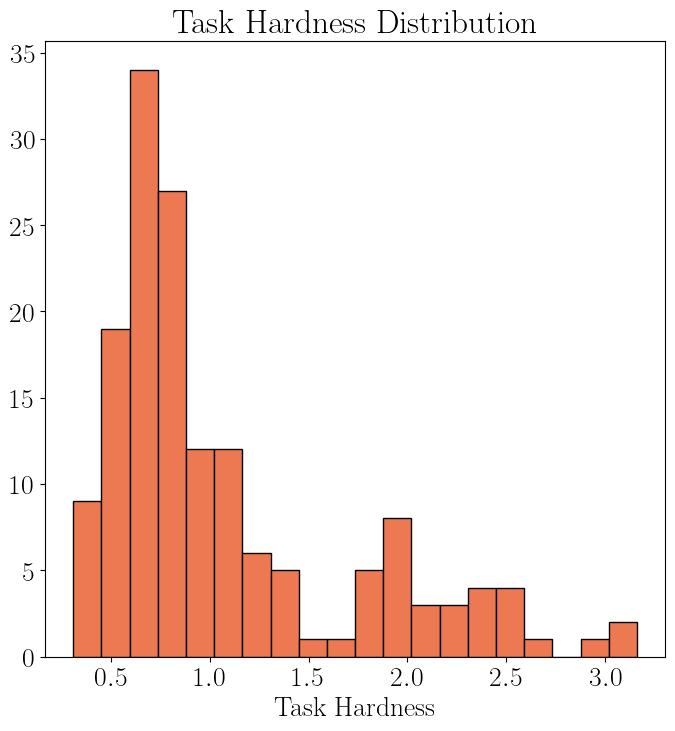

In [65]:
otdd_hardness_df = otdd_hardness(k=10, train_tasks_weighted=True)
otdd_hardness_df['hardness_norm'] = normalize(otdd_hardness_df['hardness']) 
# Visualizing the Hardness Distribution
_, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.hist(otdd_hardness_df['hardness'], bins=20, color=light_color, edgecolor=dark_color)
ax.set_title("Task Hardness Distribution")
ax.set_xlabel("Task Hardness")
plt.show()

In [66]:
otdd_hardness_df = internal_hardness(otdd_hardness_df)
otdd_hardness_df['internal_hardness_norm'] = normalize(otdd_hardness_df['internal_hardness'])

In [67]:
otdd_hardness_df

,hardness,assay,hardness_norm,internal_hardness,internal_hardness_norm
0,2.424076,CHEMBL1066254,0.741555,0.191983,0.231634
1,2.035962,CHEMBL1006005,0.605543,0.410372,0.669951
2,0.314592,CHEMBL1243970,0.002298,0.261936,0.372033
3,1.047435,CHEMBL1613907,0.259119,0.410860,0.670929
4,1.114185,CHEMBL1963825,0.282511,0.340336,0.529385
...,...,...,...,...,...
152,0.908645,CHEMBL915809,0.210481,0.172141,0.191812
153,1.194488,CHEMBL3887759,0.310653,0.392130,0.633337
154,0.904967,CHEMBL819742,0.209192,0.076572,0.000000
155,0.801774,CHEMBL2219270,0.173029,0.520346,0.890674


Peasrson Inter-tasks hardness vs Performance measure -0.6272649099569214
Peasrson Intra-tasks hardness vs Performance measure -0.4109128375064308
-0.5618335017157113


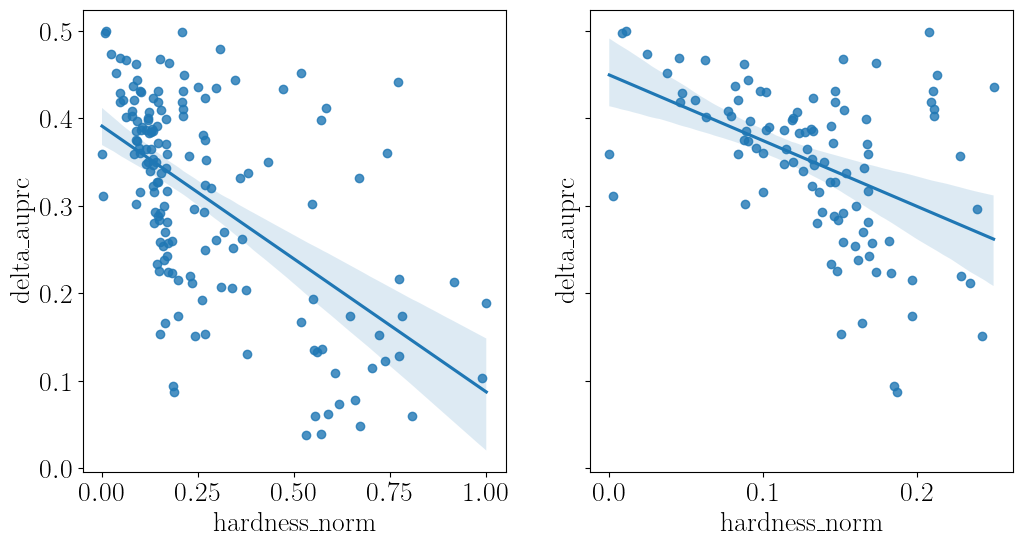

In [71]:
x = pd.merge(output_results[['assay', 'delta_auprc', 'roc_auc']], otdd_hardness_df, on="assay")
print("Peasrson Inter-tasks hardness vs Performance measure", x['hardness_norm'].corr( x['roc_auc']))
print("Peasrson Intra-tasks hardness vs Performance measure", x['internal_hardness_norm'].corr( x['roc_auc']))


z = x[x['hardness_norm'] < 0.25]
print(z['hardness'].corr( z['roc_auc']))

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(12, 6))
sns.regplot(x="hardness_norm", y="delta_auprc", data=x, ax=ax1)
sns.regplot(x="hardness_norm", y="delta_auprc", data=z, ax=ax2)
#ax[0].set(xlabel='chemical space hardness')
#ax[1].set(xlabel='chemical space hardness')
plt.show()

Peasrson Intra-tasks hardness vs Performance measure -0.4109128375064308


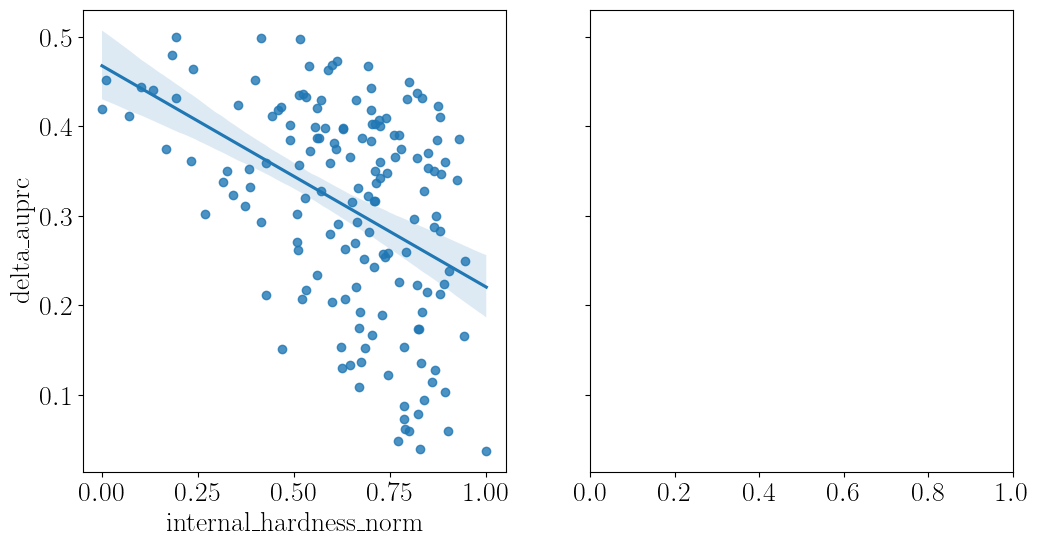

In [72]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(12, 6))
print("Peasrson Intra-tasks hardness vs Performance measure", x['internal_hardness_norm'].corr( x['roc_auc']))
sns.regplot(x="internal_hardness_norm", y="delta_auprc",data=x, ax=ax1)
#sns.regplot(x="internal_hardness_norm", y="delta_auprc",data=x, ax=ax2)
plt.show()

In [49]:
k = [1, 10, 50, 100, 500, 1000, 4000]
corr_diff_k = []
for item in k:
    otdd_hardness_df = otdd_hardness(k=item, train_tasks_weighted=True)
    otdd_hardness_df['hardness_norm'] =normalize(otdd_hardness_df['hardness']) 
    m = pd.merge(output_results[['assay', 'delta_auprc', 'roc_auc']], otdd_hardness_df, on="assay")
    corr_diff_k.append(m['hardness_norm'].corr(m['roc_auc']))

dict_keys(['train_chembl_ids', 'test_chembl_ids', 'distance_matrices'])
Numebr of NaN values in the hardness matrix:  1
dict_keys(['train_chembl_ids', 'test_chembl_ids', 'distance_matrices'])
Numebr of NaN values in the hardness matrix:  1
dict_keys(['train_chembl_ids', 'test_chembl_ids', 'distance_matrices'])
Numebr of NaN values in the hardness matrix:  1
dict_keys(['train_chembl_ids', 'test_chembl_ids', 'distance_matrices'])
Numebr of NaN values in the hardness matrix:  1
dict_keys(['train_chembl_ids', 'test_chembl_ids', 'distance_matrices'])
Numebr of NaN values in the hardness matrix:  1
dict_keys(['train_chembl_ids', 'test_chembl_ids', 'distance_matrices'])
Numebr of NaN values in the hardness matrix:  1
dict_keys(['train_chembl_ids', 'test_chembl_ids', 'distance_matrices'])
Numebr of NaN values in the hardness matrix:  1


In [50]:
corr_diff_k

[-0.6293434096531909,
 -0.6272649099569214,
 -0.5691604264110014,
 -0.519270341414249,
 -0.3601220403976118,
 -0.25872697328487665,
 -0.2367893403285891]

In [51]:
protein_hardness_df = pd.read_csv(os.path.join('tmp', 'protein_hardness_esm2_650.csv'))

In [52]:
final_df = pd.merge(protein_hardness_df, x, on="assay")

In [57]:
final_df['inter_protein_hardness_norm'] = final_df['protein_hardness_mean_norm'] + final_df['hardness_norm']
final_df['inter_intra_protein_hardness_norm'] = final_df['inter_protein_hardness_norm'] + final_df['internal_hardness_norm']

-0.43868163677248484
-0.6272649099569214
-0.6358024757264285
-0.7553039748622565


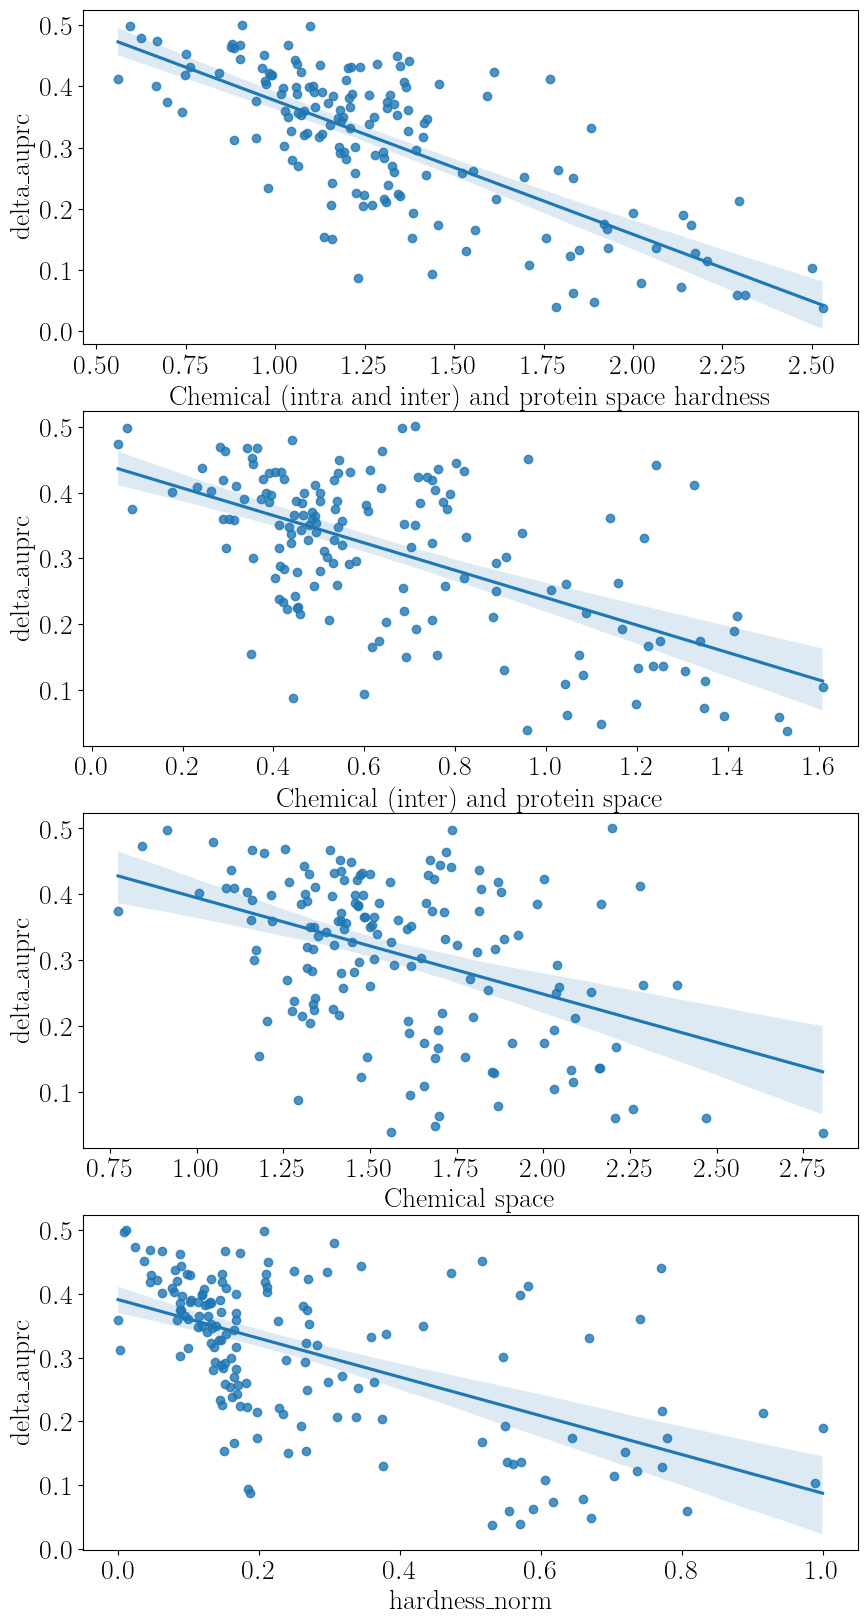

In [74]:
print(final_df['protein_hardness_mean'].corr( final_df['roc_auc']))
print(final_df['hardness'].corr( final_df['roc_auc']))
print(final_df['inter_protein_hardness_norm'].corr( final_df['roc_auc']))
print(final_df['inter_intra_protein_hardness_norm'].corr( final_df['roc_auc']))


fig, (ax0, ax1, ax2, ax3) = plt.subplots(4, 1, figsize=(10, 20))
sns.regplot(x="inter_intra_protein_hardness_norm", y="delta_auprc",data=final_df, ax=ax0)
sns.regplot(x="inter_protein_hardness_norm", y="delta_auprc", data=final_df, ax=ax1)
sns.regplot(x="protein_hardness_mean", y="delta_auprc", data=final_df, ax=ax2)
sns.regplot(x="hardness_norm", y="delta_auprc",data=final_df, ax=ax3)

ax0.set(xlabel='Chemical (intra and inter) and protein space hardness')
ax1.set(xlabel='Chemical (inter) and protein space')
ax2.set(xlabel='Protein space')
ax2.set(xlabel='Chemical space')
plt.show()

-0.6358024757264285
0.46762794102595573
0.0182235012701141


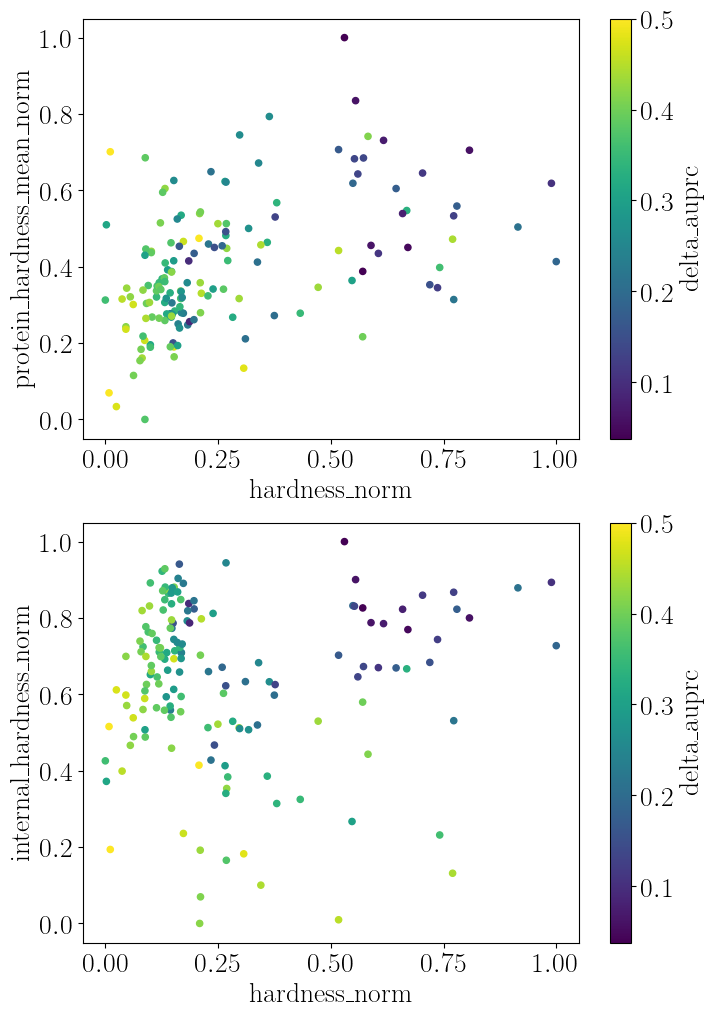

In [79]:
print((final_df['hardness_norm'] + final_df['protein_hardness_mean_norm']).corr( final_df['roc_auc']))
print(final_df['hardness_norm'].corr( final_df['protein_hardness_mean_norm']))
print(final_df['hardness_norm'].corr( final_df['internal_hardness_norm']))

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(8, 12))
final_df.plot.scatter(x='hardness_norm', y='protein_hardness_mean_norm', c='delta_auprc', colormap='viridis', ax=ax0)
final_df.plot.scatter(x='hardness_norm', y='internal_hardness_norm', c='delta_auprc', colormap='viridis', ax=ax1)  
plt.show()

In [57]:
PATH_TO_OTDD = os.path.join(FS_MOL_DATASET_PATH, 'test/hardness/otdd_unimol.pkl')
with open(PATH_TO_OTDD, 'rb') as f:
    data = pickle.load(f)

In [58]:
dfcl = pd.DataFrame(torch.stack(data['distance_matrices']))
#sns.clustermap(dfcl, cmap='viridis')

In [59]:
dfcl.fillna(0, inplace=True)

In [60]:
dfcl.corr()

,0,1,2,3,4,5,6,7,8,9,...,147,148,149,150,151,152,153,154,155,156
0,1.000000,0.906184,0.810544,0.754906,0.759075,0.876758,0.852324,NaN,0.767819,0.863920,...,0.927177,0.477504,0.593795,0.639969,0.726214,0.873562,0.780353,0.920365,0.826828,0.662300
1,0.906184,1.000000,0.777873,0.780815,0.836191,0.899840,0.858541,NaN,0.805210,0.906054,...,0.971523,0.563409,0.716375,0.717865,0.858954,0.891485,0.804509,0.899366,0.887996,0.744295
2,0.810544,0.777873,1.000000,0.885715,0.935262,0.927926,0.960679,NaN,0.916193,0.917326,...,0.882085,0.625963,0.552326,0.755215,0.677869,0.891211,0.823901,0.644356,0.881812,0.796021
3,0.754906,0.780815,0.885715,1.000000,0.937922,0.939915,0.937526,NaN,0.976823,0.940849,...,0.873075,0.852935,0.797715,0.939448,0.852417,0.934038,0.917730,0.652166,0.805442,0.952211
4,0.759075,0.836191,0.935262,0.937922,1.000000,0.963004,0.970603,NaN,0.976914,0.963175,...,0.918705,0.765321,0.701116,0.877645,0.796911,0.902938,0.863591,0.631827,0.910632,0.892738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,0.873562,0.891485,0.891211,0.934038,0.902938,0.948600,0.933777,NaN,0.921146,0.952657,...,0.937417,0.732573,0.797811,0.850006,0.877957,1.000000,0.913882,0.826759,0.843290,0.894216
153,0.780353,0.804509,0.823901,0.917730,0.863591,0.856198,0.839932,NaN,0.883979,0.868257,...,0.851799,0.860125,0.871034,0.907175,0.892274,0.913882,1.000000,0.682941,0.723283,0.929808
154,0.920365,0.899366,0.644356,0.652166,0.631827,0.775277,0.726652,NaN,0.637661,0.770798,...,0.855035,0.366946,0.598906,0.529108,0.734243,0.826759,0.682941,1.000000,0.733569,0.569112
155,0.826828,0.887996,0.881812,0.805442,0.910632,0.931307,0.929787,NaN,0.866674,0.922506,...,0.935541,0.521259,0.536792,0.686362,0.700795,0.843290,0.723283,0.733569,1.000000,0.715592


In [125]:
## Find the correlation between Hardness and assay size
target_info = pd.read_csv(os.path.join(FS_MOL_DATASET_PATH, 'target_info.csv'))
l = []
EC_super_class_name = []
protein_super_family = []
for assay in x['assay']:
    l.append(target_info['cleaned_size'][target_info['chembl_id'] == assay].values[0])
    protein_super_family.append(target_info['protein_super_family'][target_info['chembl_id'] == assay].values[0])
    EC_super_class_name.append(target_info['EC_super_class_name'][target_info['chembl_id'] == assay].values[0])

x['assay_size'] = l
x['protein_super_family'] = protein_super_family
x['EC_super_class_name'] = EC_super_class_name

In [126]:
print(x['assay_size'].corr( x['hardness_norm']))

0.3388549591820092


In [132]:
a = x[x['EC_super_class_name'] == 'transferase']
a['hardness'].corr( a['roc_auc'])

-0.5060789142088088

<Axes: xlabel='hardness_norm', ylabel='roc_auc'>

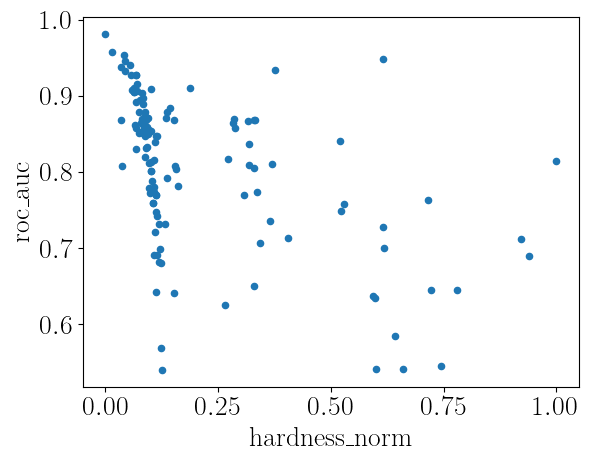

In [133]:
a.plot.scatter(x='hardness_norm', y='roc_auc')

In [127]:
x['protein_super_family'].value_counts()

protein_super_family
kinase                      100
undefined enzyme/protein     11
transferase                  10
protease                      9
epigenetic                    8
phosphatase                   4
reductase                     3
lyase                         2
cytochrome                    2
transporter                   2
hydrolase                     2
nuclear                       1
cytosolic                     1
aminoacyltransferase          1
ligase                        1
Name: count, dtype: int64

In [129]:
def otdd_hardness_experimental(k=10, weighted = False):    
    PATH_TO_OTDD = os.path.join(FS_MOL_DATASET_PATH, 'test/hardness/otdd_gin_supervised_infomax.pkl')
    with open(PATH_TO_OTDD, 'rb') as f:
        data = pickle.load(f)

    ## data is a dictionary with following keys:
    print(data.keys())

    ## data['distnce_matrices] is a list. We will convert it to the pytorch tensor
    distance_matrix = torch.stack(data['distance_matrices']) # shape: #TRAIN_TASK * TEST_TASKS

    if weighted:
        ## We will weight the distance matrix by the hardness of the closest train tasks
        with open(os.path.join(FS_MOL_DATASET_PATH, 'train/hardness/rf_16.pkl'), 'rb') as f:
            train_tasks_hardness = pickle.load(f)
        weights = calculate_task_hardness_weight(data['train_chembl_ids'], train_tasks_hardness)
        weighted_distance_matrix = weights[:, None] * distance_matrix
        a = weighted_distance_matrix
    else:
        a = distance_matrix
    
    distance_matrix_sorted,  distance_matrix_indices = torch.sort(a, dim=0)

    results = torch.mean(distance_matrix_sorted[:k, :], dim=0)
    #distance_matrix_sorted,  distance_matrix_indices = torch.sort(distance_matrix, dim=0)
    ## Some entries can contain nan values. We will replace them with mean of the results.
    print("Numebr of NaN values in the hardness matrix: ", torch.isnan(results).sum().item())
    results = torch.nan_to_num(results, nan=torch.nanmean(results).item())

    hardness_df = pd.DataFrame({'hardness':results, 'assay': data['test_chembl_ids']})
    return hardness_df